In [52]:
#This header file contains all the common packages
%run header.ipynb
phi_1d=np.load("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string))
phi_w_1d=np.load("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string))
e_list=np.load("/home/cz136/project/sa/data/{}/e_array.npy".format(dir_string))
print(dir_string)

vol_high_z


In [53]:
print(len(clusters))
print(len(shapes))

11944
344627


In [54]:
def drop_poor_centers():
    """Drop clusters with no center shape data from the cluster dataframe"""
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    pp=shapes.loc[center_id][('All','PP')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(pp)].index
    clusters.drop(missing_mem_match_id,inplace=True)
    np.save("/home/cz136/project/sa/data/{}/missing_centers.npy".format(dir_string),center_id[np.isnan(pp)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(pp))))
    print("The number of clusters with low probability center {}".format(np.sum(pp[~np.isnan(pp)]<=0.55)))
drop_poor_centers()

The number of clusters with no center shape data 0
The number of clusters with low probability center 15


In [55]:
# Print the numbers of galaxies that needed to be masked


print(np.sum(shapes[('All','e1')]==-9999))
print(np.sum(shapes[('All','e2')]==-9999))
print(np.sum(shapes['All','flags_select']==0))
print(np.sum(shapes[('All','PP')]<=0.55))

0
0
344627
156857


In [56]:
#masking


shapes=shapes[shapes[('All','PP')]>=0.55]
# shapes=shapes[shapes[('All','e1')]!=-9999]
# shapes=shapes[shapes[('All','e2')]!=-9999]
shapes=shapes[shapes[('All', 'flags_select')]==0]


print(len(clusters))
print(len(shapes))

11944
187770


# Stats of e1,e2

count    187770.000000
mean         -0.000244
std           0.148255
min          -0.728444
25%          -0.081364
50%          -0.000145
75%           0.080664
max           0.852003
Name: (All, e2), dtype: float64

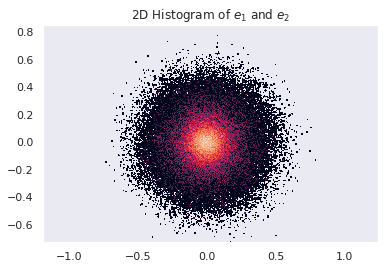

In [57]:
from matplotlib.colors import LogNorm 
plt.hist2d(shapes['All','e1'],shapes['All','e2'],bins=500,norm=LogNorm())
plt.axis('equal')
plt.title("2D Histogram of $e_1$ and $e_2$")
pd.Series(shapes['All','e1']).describe()
pd.Series(shapes['All','e2']).describe()

count    187770.000000
mean          0.809347
std         280.875798
min      -44173.333800
25%          -1.006517
50%           0.000583
75%           0.999634
max       67310.028672
dtype: float64

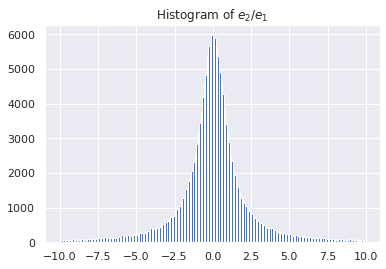

In [58]:
#statistics and hisgoram of e2/e1
plt.hist(shapes['All','e2']/shapes['All','e1'],bins=np.arange(-10,10,0.1))
plt.title("Histogram of $e_2$/$e_1$")
pd.Series(shapes['All','e2']/shapes['All','e1']).describe()

# Get phi 

In [59]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [60]:
def get_theta_for_obj(obj1,obj2):
    
    """Theta is the position angle of obj2 from north of east of obj1 """
    
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [61]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(-e2,-e1)*180/np.pi
    return(α)

In [62]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    """Input: cluster series
        Output: an array of position angle weighted by PP
        Record KeyError in an array (usually caused by uncomplete shape catalog).
    """
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        pp=members[('All','PP')]
        phi=(pa-theta)
        phi_w=(pa-theta)*pp
    #     print(center.index)
        return(phi,phi_w)    
    except KeyError as e:
        error_list_phi.append(e)
        return(np.array([]),np.array([]))

In [48]:
phi_list=[]
phi_w_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[0]
    phi_w_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[1]
    phi_w_list.append(phi_w_array)
    phi_list.append(phi_array)
phi_list=np.array(phi_list)
phi_w_list=np.array(phi_w_list)

In [49]:
def process_phi(phi_list):

    phi_1d=np.concatenate(phi_list)

    phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
    phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
    phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

    phi_1d=np.sort(phi_1d)
    
    return(phi_1d)

phi_1d=process_phi(phi_list)
phi_w_1d=process_phi(phi_w_list)

In [51]:
np.save("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string),phi_1d)
np.save("/home/cz136/project/sa/data/{}/phi_w_1d.npy".format(dir_string),phi_w_1d)

## Stats for unweighted 

In [63]:
# phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.527444e+01 
StdE:5.942942e-02 


count    187693.000000
mean         45.274435
std          25.747004
min           0.001486
25%          22.500000
50%          45.418138
75%          67.500000
max          89.999729
dtype: float64

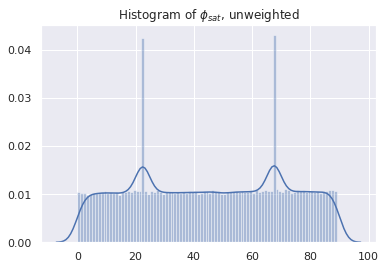

In [64]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$, unweighted") 
pd.Series(phi_1d).describe()

## Stats for weighted

In [65]:
pd.Series(phi_w_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.527444e+01 
StdE:5.942942e-02 


count    187693.000000
mean         45.274435
std          25.747004
min           0.001486
25%          22.500000
50%          45.418138
75%          67.500000
max          89.999729
dtype: float64

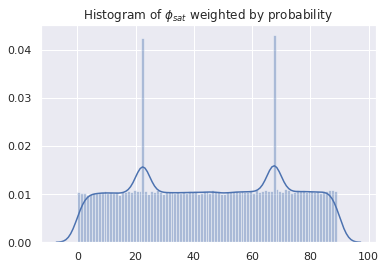

In [66]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$ weighted by probability") 
pd.Series(phi_w_1d).describe()

# Analysis around 22.5 and 67.5

In [67]:
#Print out the most crowded bins

phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[67 22 68 71 64 72 77 61 75 59 46 86 87 19 27 63 44 21 43 54 56 40 20 80
 88 76 84 82 47 25  9 38 48 66 85 23 69 79 65 17 53 70 51 13  0 36 30 55
 28 78 62 31 18 58 81 57 15 39  8 34 32 26 52 74 11 16 37  5 42 45  1 35
 33 83 10 60  6 12  2 73  7 29 49 41 24  4 50  3 14]
[7995 7898 2059 2049 2034 2033 2024 2021 2014 2013 2013 2009 2008 2004
 2003 1998 1998 1994 1991 1991 1990 1988 1986 1985 1983 1980 1979 1978
 1977 1974 1973 1972 1971 1971 1970 1970 1968 1966 1965 1965 1961 1961
 1960 1960 1960 1959 1958 1957 1956 1954 1953 1952 1951 1949 1948 1946
 1945 1944 1944 1939 1937 1932 1928 1927 1926 1925 1922 1919 1918 1918
 1916 1915 1914 1914 1913 1912 1910 1906 1902 1891 1891 1874 1863 1863
 1857 1850 1848 1831 1808]


count    7995.000000
mean       22.506796
std         0.152955
min        22.001008
25%        22.500000
50%        22.500000
75%        22.500000
max        23.046350
dtype: float64

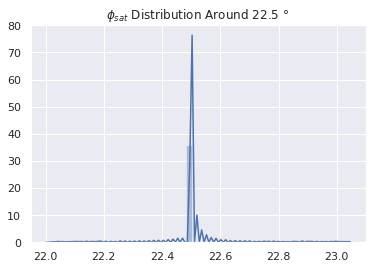

In [68]:
#Statistics around 22.5
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 $\degree$")
pd.Series(first_cluster).describe()

count    7995.000000
mean       67.499785
std         0.144316
min        67.000531
25%        67.500000
50%        67.500000
75%        67.500000
max        67.999551
dtype: float64

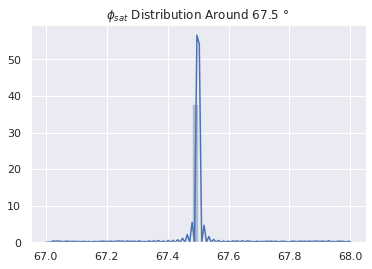

In [69]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 $\degree$")
pd.Series(second_cluster).describe()

# Get e

## Statistics of e1 and e2

In [70]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    187770.000000
mean          0.000233
std           0.147559
min          -0.733436
25%          -0.080043
50%          -0.000126
75%           0.080633
max           0.789564
Name: (All, e1), dtype: float64

In [71]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    187770.000000
mean         -0.000244
std           0.148255
min          -0.728444
25%          -0.081364
50%          -0.000145
75%           0.080664
max           0.852003
Name: (All, e2), dtype: float64

In [72]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [73]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [63]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [74]:
np.save("/home/cz136/project/sa/data/{}/e_array".format(dir_string),e_list)

In [75]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

mean=-1.086872e-03, std_mean=3.439969e-04


count    187693.000000
mean         -0.001087
std           0.149032
min          -0.707431
25%          -0.084702
50%          -0.000076
75%           0.081266
max           0.790708
dtype: float64

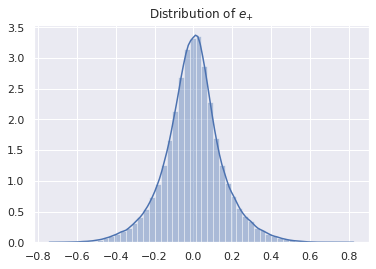

In [76]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print ("mean={:05e}, std_mean={:05e}".format(e_p_1d.mean(),get_std_err_of_mean(e_p_1d)))
pd.Series(e_p_1d).describe()

mean=2.697903e-03, std_mean=3.387123e-04


count    187693.000000
mean          0.002698
std           0.146743
min          -0.750668
25%          -0.075867
50%           0.006274
75%           0.081558
max           0.786804
dtype: float64

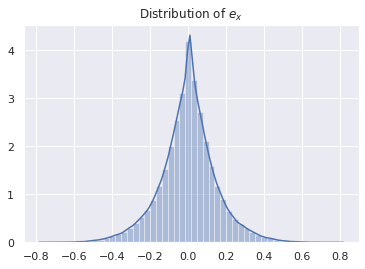

In [77]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print ("mean={:05e}, std_mean={:05e}".format(e_x_1d.mean(),get_std_err_of_mean(e_x_1d)))
pd.Series(e_x_1d).describe()